In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('../data/df_clean_v1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6542 entries, 0 to 6541
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               6542 non-null   object 
 1   target             6542 non-null   int64  
 2   word_count         6542 non-null   int64  
 3   stop_word_count    6542 non-null   int64  
 4   url_count          6542 non-null   int64  
 5   mean_word_length   6542 non-null   float64
 6   char_count         6542 non-null   int64  
 7   punctuation_count  6542 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 409.0+ KB


In [3]:
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df["text"].fillna(""))

X_num = StandardScaler().fit_transform(
    df.select_dtypes(include=[np.number]).drop(columns=["target"])
)

X = hstack([X_text, X_num])
y = df["target"].values
X.shape, y.shape

((6542, 12674), (6542,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

In [ ]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 5))
    
    
    plt.figure(figsize=(8, 5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

In [6]:
dict_of_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

training models:   0%|          | 0/5 [00:00<?, ?it/s]

LogisticRegression
[[262  66]
 [ 86 241]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       328
           1       0.79      0.74      0.76       327

    accuracy                           0.77       655
   macro avg       0.77      0.77      0.77       655
weighted avg       0.77      0.77      0.77       655

DecisionTree
[[236  92]
 [120 207]]
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       328
           1       0.69      0.63      0.66       327

    accuracy                           0.68       655
   macro avg       0.68      0.68      0.68       655
weighted avg       0.68      0.68      0.68       655

RandomForest
[[280  48]
 [120 207]]
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       328
           1       0.81      0.63      0.71       327

    accuracy                           0.74       655
   macro avg  

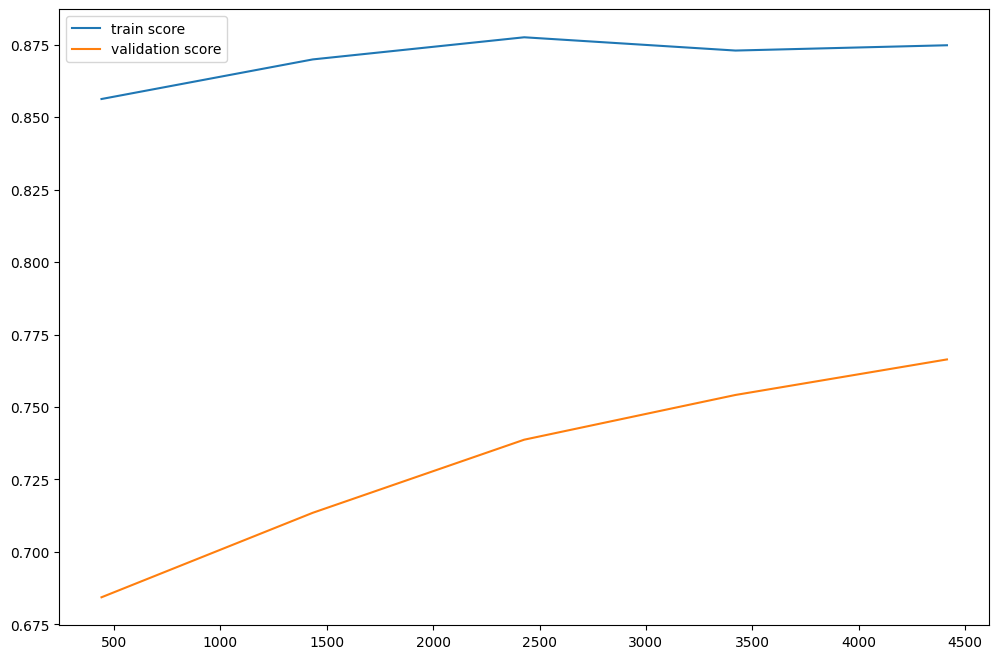

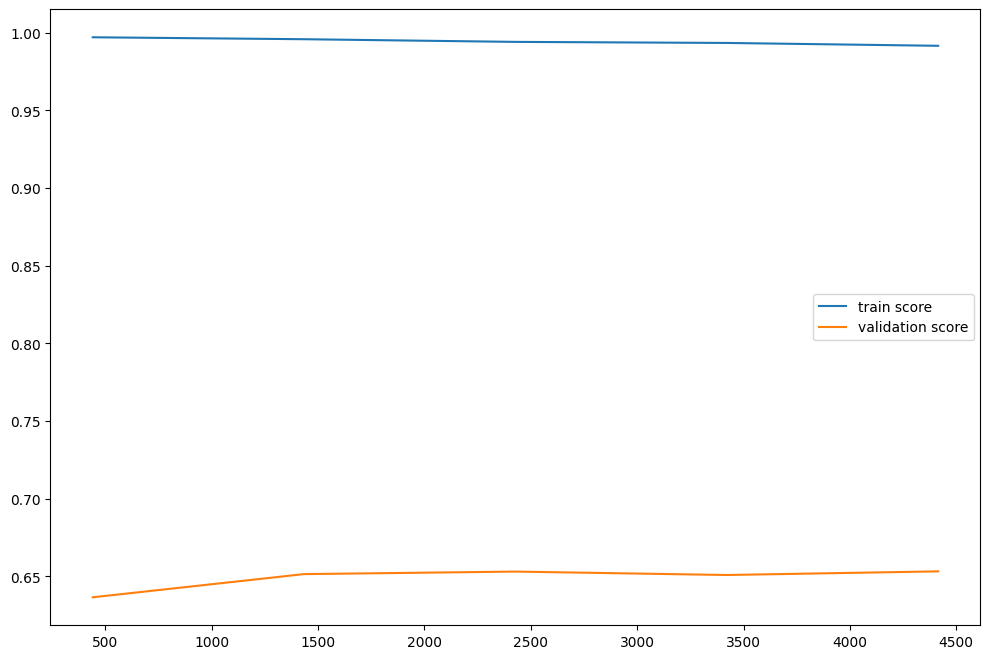

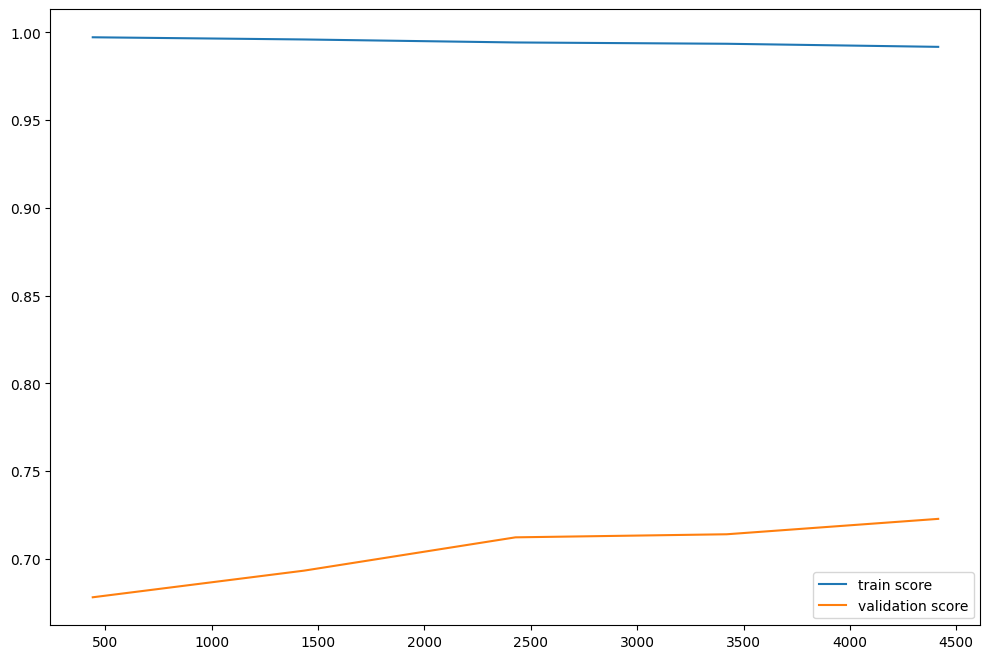

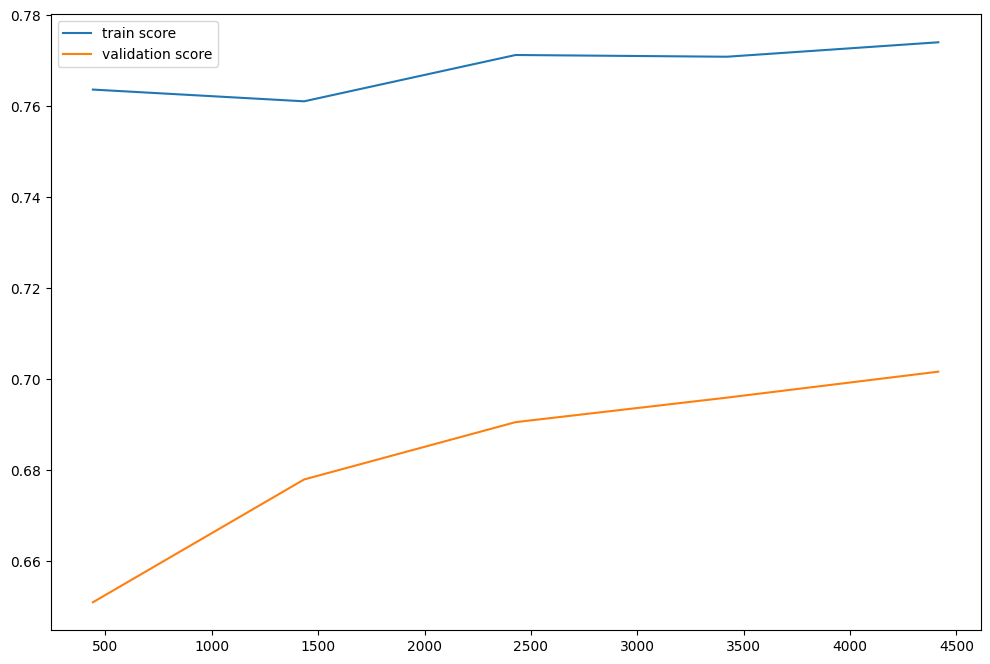

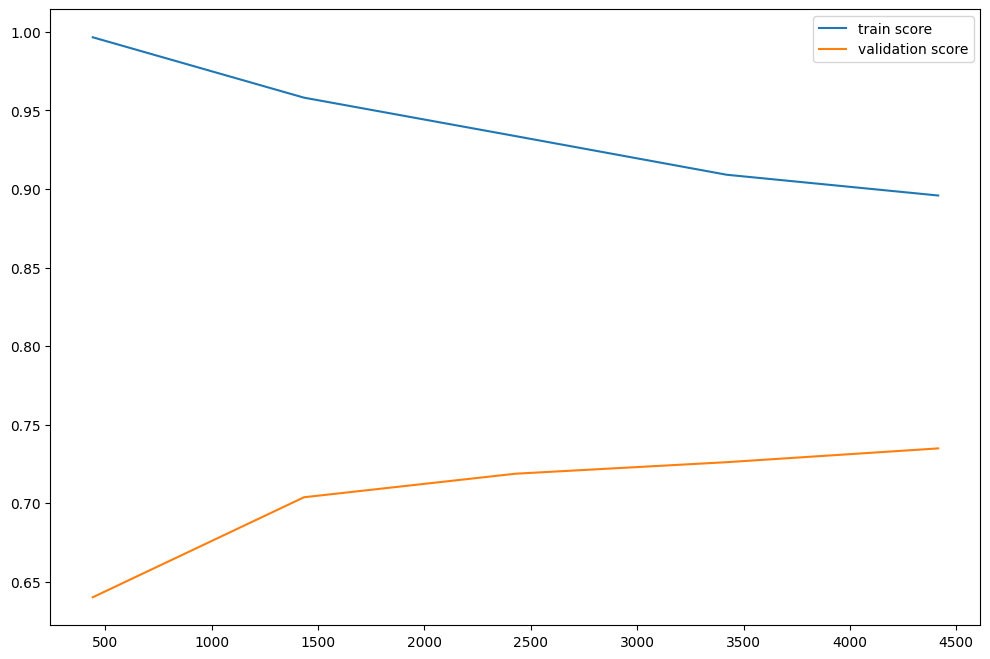

In [7]:
for name, model in tqdm(dict_of_models.items(), desc="training models"):
    print(name)
    evaluation(model)

- Démarche

Nous avons séparé notre jeu de données en 90% pour l’apprentissage et 10% pour le test.

Après l’entraînement, nous avons mesuré l'accuracy, le recall et le score F1.

La courbe d’apprentissage montre l’évolution des performances en fonction de la taille de l’échantillon d’entraînement, nous avons entraîné chaque modèle plusieurs fois, en utilisant des sous-ensembles représentant 10%, 20%, … jusqu’à 100% des données disponibles pour l’apprentissage.

Le validation score mesure la performance du model sur des donnée d'entrainement, il permet de le descriminer sur des données encore jamais vues.

Cela permet d'analyser la convergence, l'overfitting et le potentiel avec plus de données.

- Interprétation

Sur nos données, LR obtient nativement le meilleur score F1 (0.76) parmi les modèles testés.
Il représente un équilibre entre la précision et recall, une bonne généralisation, nous nous focalisons sur celui de la classe 1 car c'est ce que nous cherchons à prédire.

Nous avons donc choisi de conserver LR comme modèle de base et de procéder à un fine tuning afin de tenter d’améliorer encore ses performances.

### LR

In [9]:
log_reg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],         
    'penalty': ['l2'],               
    'solver': ['lbfgs', 'saga']      
}

grid_search = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,                
    scoring='f1',        
    n_jobs=-1, # Pleine puissance
    verbose=2
)

grid_search.fit(X_train, y_train)
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score F1 (val) :", grid_search.best_score_)
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.1s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ....................C=0.1, penalty=l2, s

/home/antoine/Desktop/plateforme/eye-of-emergency/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/antoine/Desktop/plateforme/eye-of-emergency/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/antoine/Desktop/plateforme/eye-of-emergency/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/antoine/Desktop/plateforme/eye-of-emergency/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/antoine/Desktop/plateforme/eye-of-emergency/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: C

[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.2s
Meilleurs hyperparamètres : {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleur score F1 (val) : 0.770718615908485
Confusion Matrix:
 [[261  67]
 [ 84 243]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78       328
           1       0.78      0.74      0.76       327

    accuracy                           0.77       655
   macro avg       0.77      0.77      0.77       655
weighted avg       0.77      0.77      0.77       655

